<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [1]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

In [2]:
from google.colab import drive

drive.mount('/content/drive')

# 解壓縮 cable 資料集
#!tar -xvf drive/MyDrive/cable.tar.gz zipper

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
subdir = "/content/drive/MyDrive/DeepLearning/hw3/MVTec AD Dataset/"
print(os.listdir(subdir))  # 列出 cable 目錄下的所有檔案與資料夾

['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'license.txt', 'metal_nut', 'pill', 'readme.txt', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


In [4]:
file_paths = glob.glob('/content/drive/MyDrive/DeepLearning/hw3/MVTec AD Dataset/bottle/*/*/*.png')
file_paths = sorted([path for path in file_paths if path.split('/')[-1] in [f'{i:03}.png' for i in range(10)]])

print(f"Found {len(file_paths)} images")
print(file_paths[:5])  # 顯示前 5 個檔案路徑

Found 50 images
['/content/drive/MyDrive/DeepLearning/hw3/MVTec AD Dataset/bottle/test/broken_large/000.png', '/content/drive/MyDrive/DeepLearning/hw3/MVTec AD Dataset/bottle/test/broken_large/001.png', '/content/drive/MyDrive/DeepLearning/hw3/MVTec AD Dataset/bottle/test/broken_large/002.png', '/content/drive/MyDrive/DeepLearning/hw3/MVTec AD Dataset/bottle/test/broken_large/003.png', '/content/drive/MyDrive/DeepLearning/hw3/MVTec AD Dataset/bottle/test/broken_large/004.png']


In [5]:
# 讀取圖片資料
all_data = []

for img in tqdm(file_paths):  # tqdm 用於顯示進度條
    img = cv2.imread(img)  # 使用 OpenCV 讀取圖片 (Blue-Green-Red)
    img = img[..., ::-1]  # 將 BGR 轉為 RGB（Red-Green-Blue）>>for 深度學習模型
    all_data.append(img)

all_data = np.stack(all_data) # 將 list 轉為 numpy array>>效率高、支援向量化運算
# PyTorch、TensorFlow 等框架中也傾向直接處理 array 格式的資料
print(all_data.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

(50, 900, 900, 3)


Classes: ['broken_large', 'broken_small', 'contamination', 'good']


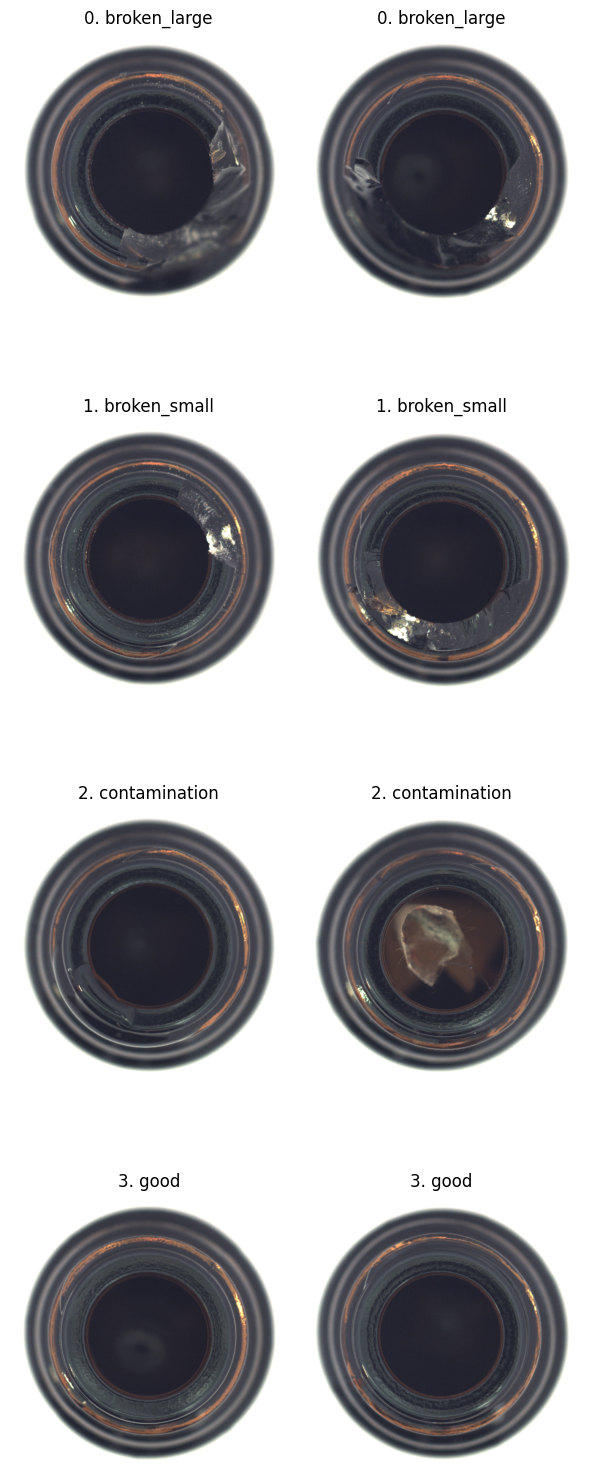

In [6]:
import matplotlib.pyplot as plt
import numpy as np

#classes = sorted(set([path.split('/')[1] for path in file_paths]))
classes = sorted(set([path.split('/')[-2] for path in file_paths]))
print(f'Classes: {classes}')

images_per_class = len(all_data) // len(classes)

# 畫出每個類別的前兩張圖片做視覺化
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

for i, class_name in enumerate(classes):
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


In [7]:
from collections import Counter
import pandas as pd

# 統計 file_paths 中每個類別的圖片數量
class_counts = Counter([path.split('/')[-2] for path in file_paths])
print("原始資料集中各類別的圖片數量:")
for cls, count in class_counts.items():
    print(f" - {cls}: {count} 張")

原始資料集中各類別的圖片數量:
 - broken_large: 10 張
 - broken_small: 10 張
 - contamination: 10 張
 - good: 20 張


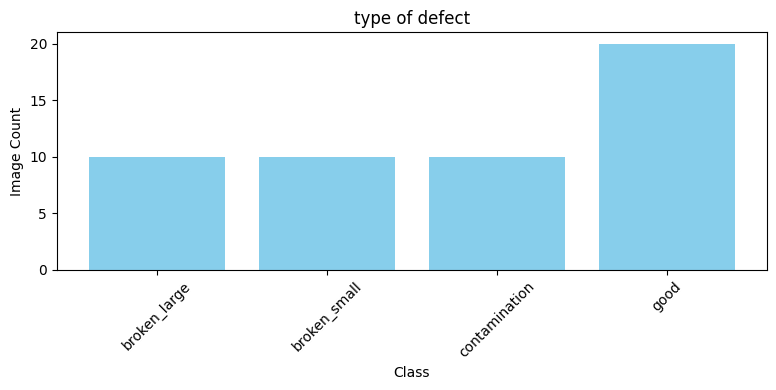

In [8]:
# 用條狀圖畫出來
plt.figure(figsize=(8,4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("type of defect")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## A. Data Loading and Preprocessing

In [9]:
# 將資料分成訓練集與驗證集

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

num_classes = 4
images_per_class = 10
train_images_per_class = int(images_per_class * 0.8)
val_images_per_class = int(images_per_class * 0.2)

x_train = []
x_val = []

# 將每個類別的圖片依比例加入訓練與驗證集
for i in range(num_classes):
    start_index = i * images_per_class
    x_train.extend(all_data[start_index:start_index + train_images_per_class])
    x_val.extend(all_data[start_index + train_images_per_class:start_index + images_per_class])

# 轉換資料格式為 PyTorch 需要的格式：(batch, channel, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))

# 建立對應的標籤
y_train = np.concatenate([np.full(train_images_per_class, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(val_images_per_class, i) for i in range(num_classes)])

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of x_train: (32, 3, 900, 900)
Shape of x_val: (8, 3, 900, 900)
Shape of y_train: (32,)
Shape of y_val: (8,)



[Train Set dis.]
broken_large: 8 張
broken_small: 8 張
contamination: 8 張
good: 8 張

[Validation Set dis.]
broken_large: 2 張
broken_small: 2 張
contamination: 2 張
good: 2 張


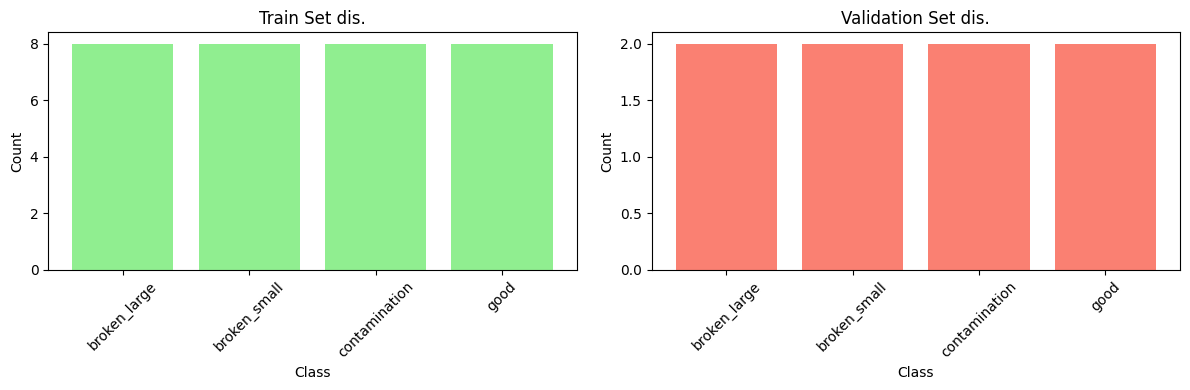

In [10]:
# 建立對應的標籤名稱
class_names = sorted(set([path.split('/')[-2] for path in file_paths]))

# 轉成 pandas DataFrame 做分析
train_df = pd.DataFrame({'label': y_train})
val_df = pd.DataFrame({'label': y_val})

# 訓練集分布
train_counts = train_df['label'].value_counts().sort_index()
val_counts = val_df['label'].value_counts().sort_index()

# 顯示統計資料
print("\n[Train Set dis.]")
for idx, count in enumerate(train_counts):
    print(f"{class_names[idx]}: {count} 張")

print("\n[Validation Set dis.]")
for idx, count in enumerate(val_counts):
    print(f"{class_names[idx]}: {count} 張")

# 視覺化分布
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].bar(class_names, train_counts, color='lightgreen')
axs[0].set_title("Train Set dis.")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Count")
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(class_names, val_counts, color='salmon')
axs[1].set_title("Validation Set dis.")
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Count")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [11]:
# 定義影像增強與轉換方法
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# 訓練集轉換：包含資料增強
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# 驗證集轉換：只做 Resize 與 ToTensor
# 驗證集不能做隨機增強，否則每次驗證結果不一致，無法公平比較模型的準確率
val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

# 自定義 Dataset 類別
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]

In [12]:
# 建立資料加載器

batch_size = 8

train_dataset = MyDataset(x_train, y_train, train_transform)
val_dataset = MyDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

## B. Defining Neural Networks

In [13]:
import torch.nn as nn
from torchvision import models

# 加載預訓練的 ResNet 模型
model = models.resnet50(weights='IMAGENET1K_V1')

# 預設先凍結所有層
for param in model.parameters():
    param.requires_grad = False

# 解凍最後的分類層（'fc' 層）
model.fc.requires_grad = True

# 凍結所有層參數（僅微調最後一層）
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 4

# 替換輸出層為我們的分類數量（原本是1000類，現在改為8類）
model.fc = nn.Linear(num_ftrs, num_class)
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## C. Training the Neural Network

In [14]:
# 設定訓練相關的超參數
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
model = model.cuda()

# 儲存最佳模型的參數
best_val_loss = float('inf')
best_val_acc = -1

# 定義 loss、optimizer、學習率調整器
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

# 開始訓練模型
for epoch in tqdm(range(epochs)):
    # -------- Training --------
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = (images) / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # -------- Validation --------
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = (images) / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # 更新學習率
    lr_scheduler.step()

    # 儲存最佳模型
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # 儲存訓練過程數據
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 1.4236, Train acc: 21.8750%, Val loss: 1.4344, Val acc: 25.0000%, Best Val loss: 1.4344 Best Val acc: 25.00%
Epoch 2/50, Train loss: 1.3905, Train acc: 34.3750%, Val loss: 1.4566, Val acc: 25.0000%, Best Val loss: 1.4344 Best Val acc: 25.00%
Epoch 3/50, Train loss: 1.4017, Train acc: 15.6250%, Val loss: 1.4974, Val acc: 25.0000%, Best Val loss: 1.4344 Best Val acc: 25.00%
Epoch 4/50, Train loss: 1.4058, Train acc: 37.5000%, Val loss: 1.5406, Val acc: 25.0000%, Best Val loss: 1.4344 Best Val acc: 25.00%
Epoch 5/50, Train loss: 1.3861, Train acc: 28.1250%, Val loss: 1.5451, Val acc: 25.0000%, Best Val loss: 1.4344 Best Val acc: 25.00%
Epoch 6/50, Train loss: 1.3774, Train acc: 25.0000%, Val loss: 1.5683, Val acc: 25.0000%, Best Val loss: 1.4344 Best Val acc: 25.00%
Epoch 7/50, Train loss: 1.3683, Train acc: 37.5000%, Val loss: 1.6242, Val acc: 25.0000%, Best Val loss: 1.4344 Best Val acc: 25.00%
Epoch 8/50, Train loss: 1.3254, Train acc: 34.3750%, Val loss: 1.6588

### Visualizing model performance

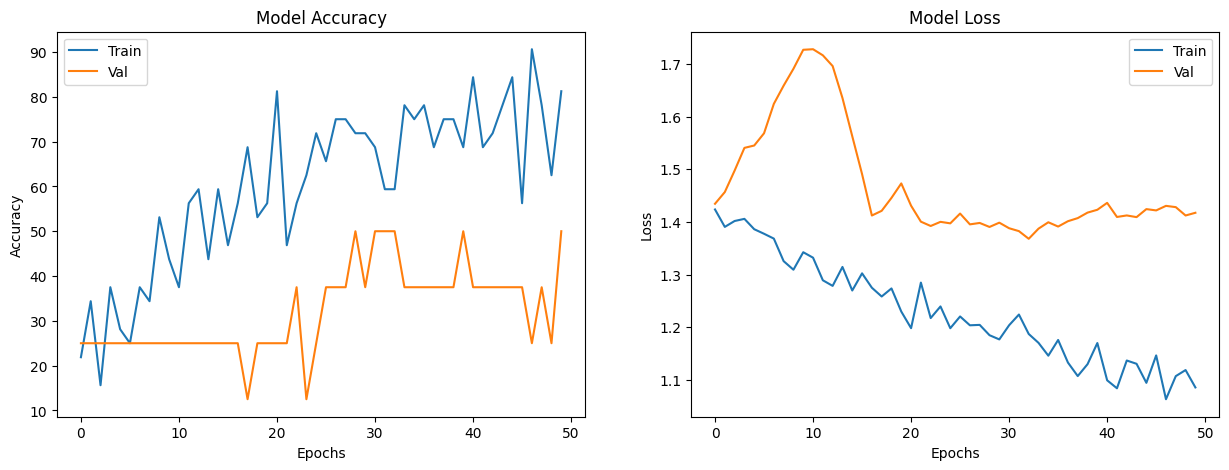

In [15]:
# 畫出訓練過程的準確率與損失變化
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [16]:
# 測試最終模型效能
# 載入最佳模型參數
model.load_state_dict(torch.load('model_classification.pth'))
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:

        images = images.cuda()
        images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels) # 真實標籤
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

tensor([2, 2, 2, 2, 2, 2, 3, 3], device='cuda:0')
tensor([0, 0, 1, 1, 2, 2, 3, 3], device='cuda:0')
Test accuracy is 50.0%
